In [8]:
import numpy as np
import matplotlib.cbook as cbook #needed to load the binary file
import os
%matplotlib nbagg
import matplotlib.pyplot as plt
from scipy.stats import zscore
import struct

In [ ]:
# path management
file = r"C:\Users\lucab\Google Drive\01 - OCT\Axial Resolution and sampling\12mm"
# file = r"C:\Users\lucab\Google Drive\01 - OCT\Axial Resolution and sampling\test_1_trLVL163_delay16_ND4_Depth_150mm.bin"
path = os.path.normpath(file) # to uniform slashes and backslashes in paths
name = os.path.basename(path)
folder = os.path.dirname(path)

N_samples = 2048 # N points acquired from photodiode - take from header 
filesize = os.path.getsize(path)
width = int(filesize/(N_samples*2))

has_header = False 

# # reading a binary file - big or little endian
with cbook.get_sample_data(path) as f:
    raw = np.frombuffer(f.read(), dtype="u2").reshape(
                (width, N_samples)).T

chunk_type = ">u2" # https://numpy.org/devdocs/user/basics.types.html
# header management
header_length = 256
header = np.fromfile(file, count = header_length, dtype = 'char')
print(header)


# raw = np.fromfile(file, dtype=chunk_type).reshape((width, N_samples)).T
###

print(f"Successfully read:\n'{name}' from folder {folder}\n{raw.shape} px")

In [19]:
# file = r"C:\Users\lucab\Google Drive\01 - OCT\Axial Resolution and sampling\test_1_trLVL163_delay16_ND4_Depth_150mm.bin"
file = r"/Users/fabioferoldi/Documents/GitHub/Python_Fabio/disp_comp/mirror12mm"
file = os.path.normpath(file)
filesize = os.path.getsize(file)

## To read the length of the header, from
# https://books.google.nl/books?id=bIZHCgAAQBAJ&pg=PT149&lpg=PT149&dq=matplotlib+cbook+for+binary+with+header&source=bl&ots=mOirMtJP6U&sig=ACfU3U1Slj4Y2r4Xkl4sKuFsBna9Syog6A&hl=en&sa=X&ved=2ahUKEwiY34fLn9fpAhUL8KQKHaIFD-oQ6AEwBHoECAoQAQ#v=onepage&q=matplotlib%20cbook%20for%20binary%20with%20header&f=false  
with open(file, 'rb') as fp:
    img = memoryview(fp.read())
fabio = False

if fabio:
    header_size = 256
    header_length_format = '>'+str(header_size)+'c'# the first 3 blocks of 16bytes define the header's length
    header = img[:header_size] # first 256 char
    header = struct.unpack(header_length_format, header)
    #### missing: converting the separate bytes into one variable header[18:22]
    h = "".join([el.decode('utf-8') for el in header])
    print(h)
    spectrumsize = int(h[18:22])
    fftsize = int(h[32:36])
    linesize = int(3/2*fftsize)
    bscansize = int(h[49:53])
    datatype = np.dtype('>i2')
    buffersize = linesize * bscansize * datatype.itemsize
    cscansize = int(filesize/(buffersize))
    del header
else:
    datatype = np.dtype('<u2')
    header_size = 0
    cscansize = 1
    linesize = 2048
    bscansize  = 256
    spectrumsize = 2048
# del img

In [23]:
## You will parse the header appropriately
filesize = os.path.getsize(file) - header_size
buffersize = linesize * bscansize * datatype.itemsize

for i in range(cscansize):
    raw = np.frombuffer(
            img[header_size+i*buffersize:header_size+(i+1)*buffersize], 
            dtype=datatype,
#             dtype=np.dtype('>i2'),
    )
    raw = raw.reshape((bscansize, linesize)).T
    raw_orig = raw
    # fabio's A-scans have the magnitude of the FFT appended - we will ignore it
    if fabio: 
        raw = raw[:spectrumsize, :]

    # apply Hanning window
    raw = np.multiply(
            raw, 
            np.hanning(spectrumsize).reshape(spectrumsize,1), # reshape is only a view, no extra memory ussage
            dtype='float32') 

    # find/apply chromatic dispersion curve
    # we'll apply a chromatic dispersion curve equal and opposed to the system's one
    k = np.arange(spectrumsize)
    k = zscore(k)
    curve = np.polyval([0, -4, 0, 0], k)
    disp_comp = np.exp(1j*curve, dtype='complex64').reshape(spectrumsize,1)
    raw = np.multiply(raw, disp_comp, dtype='complex64')
    
    # zeropad (best way is to split the spectrum, invert the parts and put zeros in between)
    padded_size = 1024 # or 1, for what it matters
    padding_factor = 1
    while raw.shape[0] > padded_size*padding_factor:
        padded_size *= 2
    
    raw = np.concatenate((
        raw[ int(spectrumsize/2) : , :],
        np.zeros( (padded_size-spectrumsize, bscansize), dtype='complex64' ),
        raw[ : int(spectrumsize/2) , :]
    ))
    
    # FFT to obtain electric fields   
    # -> Modulus
    # -> LOG
    bscan = np.log(
                np.abs(
                    np.fft.fft(raw, axis = 0)[:int(len(raw)/2)] # this can be done on GPU! 
                ),
            dtype = np.float
    )
    
    break

# del header
# del img

<IPython.core.display.Javascript object>


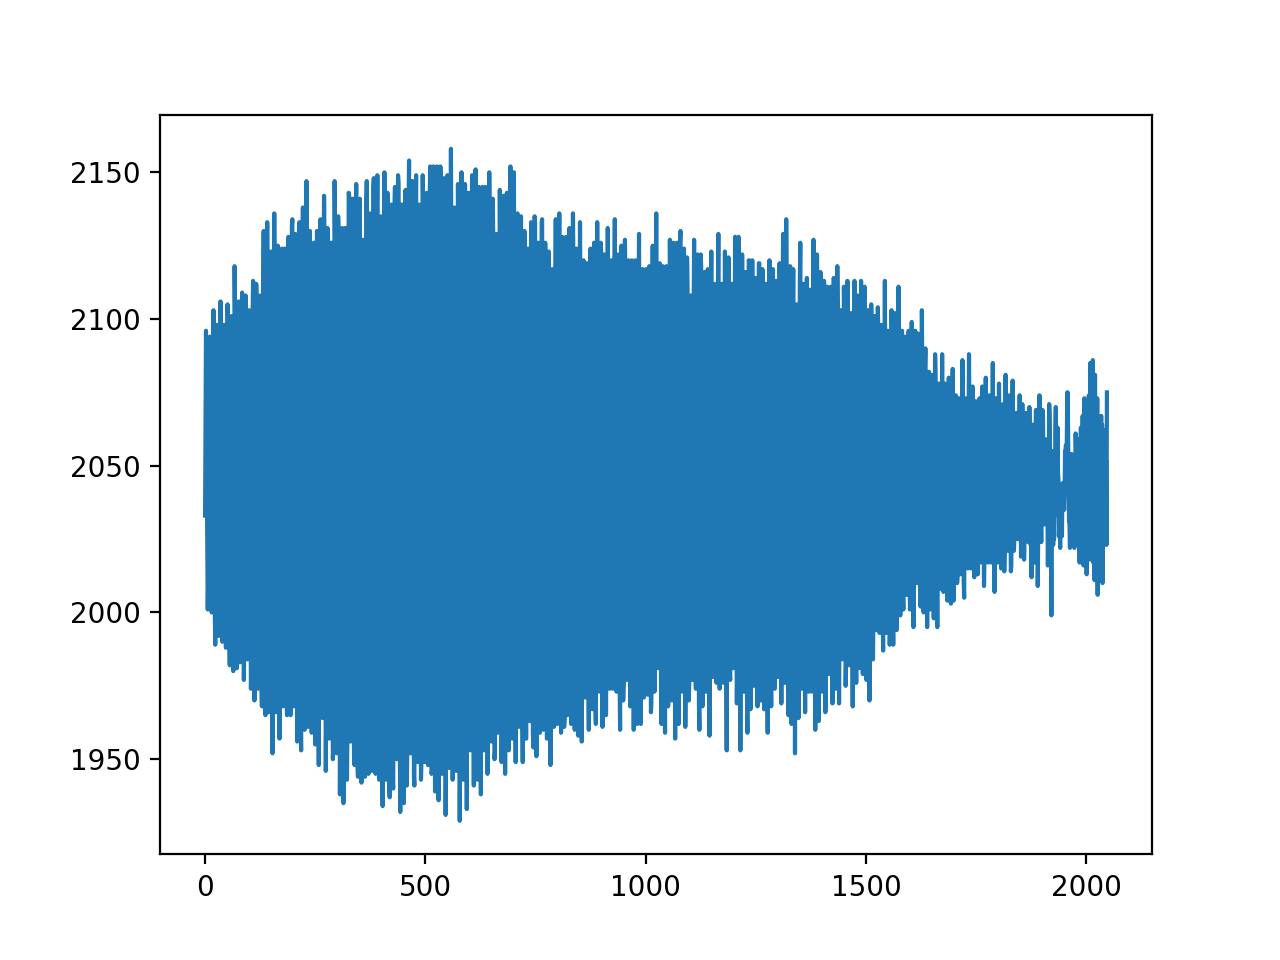

In [24]:
out = raw_orig
fig,ax = plt.subplots()
# ax.imshow(bscan)
# ax.plot(bscan[:,50])
ax.plot(out[:,50])
fig.show()

### To measure chromatic dispersion:
- image a mirror
- isolate the peak (gaussian window around peak)
- iFFT of that
- plot phase in wavenumber space
- fit polynomial to find disp_curve coeff (usually 3rd deg) - 
- constraint must be that 0th and 1st order coeff. are == 0

<IPython.core.display.Javascript object>


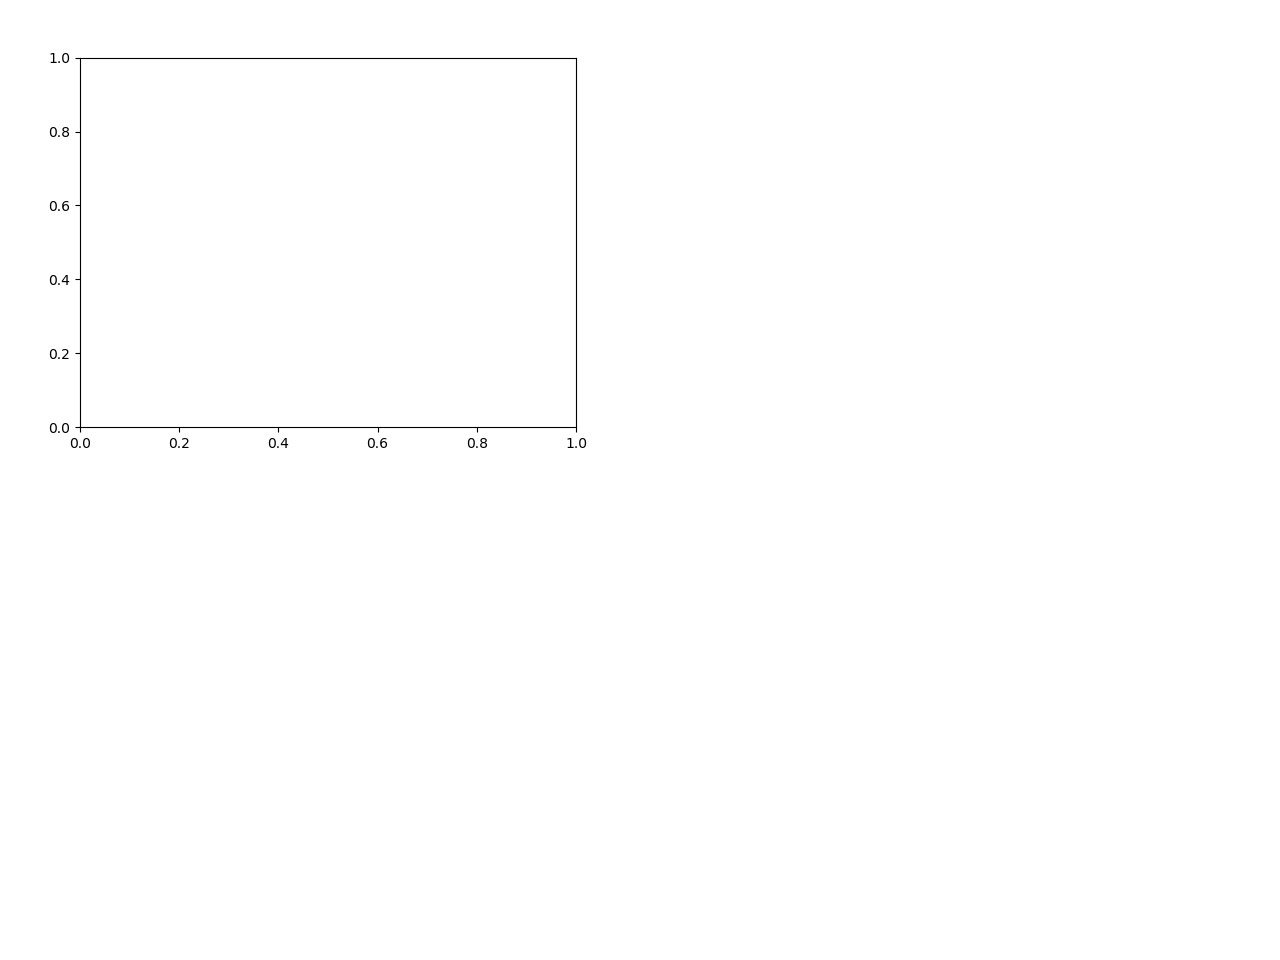

NameError: name 'out' is not defined

In [21]:
fig,ax = plt.subplots()
ax.plot(out[:,50])

### Chromatic dispersion 
- read a buffer (binary file) into np.array
- define a set of coefficients for chromatic disp comp
- apply those to the spectra
- FFT
- (log scaling) optional
- measure variance of the image (proxy for contrast)